In [129]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import glob
import ipyparallel as ipp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import iBioGen

from collections import Counter
from itertools import combinations
from IPython.display import display
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split, cross_val_score

pd.set_option('display.max_columns', None)

ipyclient = ipp.Client(cluster_id="iBioGen")
len(ipyclient)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


40

### Load simulations

In [213]:
%%time
neutral_simfile = "./default_iBioGen/sim-neutral-ntaxa300-SIMOUT.csv"
comp_simfile = "./default_iBioGen/sim-comp-ntaxa300-SIMOUT.csv"
filt_simfile = "./default_iBioGen/sim-filt-ntaxa300-SIMOUT.csv"

all_sims_params = []
all_sims_locs = []
for model, simfile in zip(["neutral", "competition", "filtering"],
                            [neutral_simfile, comp_simfile, filt_simfile]):
    params_df, loc_df = iBioGen.util.load_local_sims(simfile)
    print(model, len(params_df))
    params_df["assembly_model"] = model
    all_sims_params.append(params_df)
    all_sims_locs.append(loc_df)

all_sims_params_df = pd.concat(all_sims_params, axis=0, ignore_index=True)
all_sims_locs_df = pd.concat(all_sims_locs, axis=0, ignore_index=True)
## Prune out simulations that have low species richness
all_sims_locs_df = all_sims_locs_df[all_sims_params_df["local_S"] > 80]
all_sims_params_df = all_sims_params_df[all_sims_params_df["local_S"] > 80]
all_sims_params_df

neutral 10161
competition 11580
filtering 10644
CPU times: user 4min 50s, sys: 5.42 s, total: 4min 56s
Wall time: 4min 53s


,ClaDS_sigma,ClaDS_alpha,J,colrate,ecological_strength,local_stop_time,meta_obs_ntaxa,meta_obs_time,local_obs_time(gen),local_obs_time(eq),meta_turnover_rate,ClaDS_m,local_S,abund_h1,abund_h2,abund_h3,pi_h1,pi_h2,pi_h3,trait_h1,trait_h2,trait_h3,assembly_model
0,0.236468,0.724531,73536,0.004281,0.498976,0.560201,300,22.540360,381,0.562174,0.204244,0.745074,182,17.041488,4.829949,3.434967,82.588426,54.662249,41.623975,40.120220,13.948081,9.655527,neutral
1,0.350718,0.770225,108590,0.000157,0.182270,0.999628,299,19.715140,34621,0.999632,0.236641,0.819082,97,29.645881,19.515559,15.543295,45.263315,34.863818,29.532215,28.678997,19.493209,16.151155,neutral
2,0.295453,0.710100,128617,0.000273,5.136883,0.790083,300,40.045080,6327,0.791272,0.280576,0.741780,91,21.386077,11.632559,8.717803,49.104746,40.835216,36.449049,24.177683,14.466114,11.152378,neutral
3,0.204691,0.846823,76774,0.001539,0.252135,0.829994,300,11.759769,1208,0.830073,0.391481,0.864751,141,35.505923,16.817895,11.710675,68.509446,50.997031,42.636792,44.502549,24.897739,18.834996,neutral
5,0.377523,0.769631,119913,0.000405,4.630973,0.841776,300,18.754551,4518,0.842311,0.380165,0.826478,86,17.587749,9.893686,7.934090,43.840337,35.374341,31.575811,22.742277,11.841593,8.987671,neutral
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32371,0.103973,0.813929,86157,0.000690,0.784776,0.941381,300,16.952102,255,0.943034,0.189189,0.818341,100,11.952519,6.541432,5.060263,36.993215,26.685571,22.338325,19.930070,10.647735,8.479008,filtering
32374,0.104855,0.687503,53590,0.000550,0.142817,0.667491,300,53.133492,220,0.672383,0.197861,0.691293,89,11.140884,6.170382,4.849864,27.208487,17.125150,13.067498,12.256867,7.502006,6.191966,filtering
32376,0.143093,0.840446,102307,0.001560,3.404406,0.923471,300,18.528063,116,0.925235,0.273608,0.849095,93,11.103759,6.009007,4.613024,31.841134,25.308186,22.653913,17.002909,9.626738,7.526902,filtering
32382,0.141742,0.804835,148424,0.003831,9.571697,0.691253,300,30.004813,240,0.693830,0.152542,0.812961,141,7.057879,5.095473,4.521317,20.905686,14.081932,11.478283,12.947941,6.106060,5.169841,filtering


In [104]:
all_sims_params_df

,ntaxa,ClaDS_sigma,ClaDS_alpha,J,colrate,local_stop_time,meta_obs_ntaxa,meta_obs_time,local_obs_time(gen),local_obs_time(eq),meta_turnover_rate,ClaDS_m,local_S,abund_h1,abund_h2,abund_h3,pi_h1,pi_h2,pi_h3,trait_h1,trait_h2,trait_h3,assembly_model,ecological_strength
0,300.0,0.291505,0.622883,9842,0.004771,0.627350,300,95.336334,260,0.631173,0.234694,0.649918,94,19.585217,6.634858,4.441914,17.618257,5.336468,3.648850,30.999023,16.911854,13.172885,neutral,NaN
21,300.0,0.388667,0.613099,9545,0.004497,0.755959,300,166.671040,360,0.757150,0.395161,0.661201,86,22.791622,10.823743,7.696417,26.758786,13.937966,9.287222,25.037582,13.600665,10.435400,neutral,NaN
43,300.0,0.292984,0.672983,8305,0.004585,0.968787,301,51.237522,3631,0.972667,0.266990,0.702496,88,36.474051,23.082268,18.342049,36.765387,22.418233,16.269581,38.008190,26.008179,21.250223,neutral,NaN
49,300.0,0.216124,0.603976,9211,0.003715,0.853037,300,130.138085,550,0.853870,0.218750,0.618247,104,38.636760,22.535486,15.794592,45.428571,34.858998,28.925434,44.988249,29.338984,22.674698,neutral,NaN
56,300.0,0.191153,0.760788,7536,0.004692,0.754788,300,31.130724,280,0.758094,0.255583,0.774815,84,20.622066,9.946462,7.388227,21.427515,11.883465,9.093800,23.486474,11.700654,9.011172,neutral,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3034,NaN,0.192683,0.797507,47534,0.003224,0.679459,300,23.877607,36,0.702592,0.232737,0.812450,100,15.290963,8.047954,5.867549,31.601811,23.305865,19.827563,13.832023,8.964023,7.701372,filtering,2.516805
3036,NaN,0.291600,0.707149,97483,0.001344,0.528785,300,32.506051,7,0.736344,0.405941,0.737862,102,18.334513,9.477253,6.911050,43.683316,33.613367,28.560275,15.657242,10.090861,8.649324,filtering,3.554944
3038,NaN,0.341920,0.646300,114835,0.001687,0.646301,300,54.801063,14,0.777733,0.200000,0.685205,99,16.867014,11.093240,8.544180,32.090249,26.291349,23.509856,14.259973,10.380045,9.299821,filtering,7.010995
3040,NaN,0.170294,0.840014,145580,0.000683,0.665510,300,11.263740,424,0.666348,0.232737,0.852283,125,15.368840,7.042621,5.051808,46.343010,30.832850,23.724163,16.430336,9.521772,8.084980,filtering,0.205118


### Load empirical data

In [209]:
habitats = ["Pb", "Qa", "Cb", "Pn"]
cyprus_pis = {}
cyprus_hills = {}
for h in habitats:
    cyprus_pis[h] = open(f"./CyprusMetabarcoding/{h}_pis.txt")\
                    .read().strip().split(",")
    cyprus_pis[h] = sorted([float(x) for x in cyprus_pis[h]],
                           reverse=True)
    
    cyprus_hills[h] = open(f"./CyprusMetabarcoding/{h}_hills.txt")\
                    .read().strip().split(",")
    cyprus_hills[h] = [float(x) for x in cyprus_hills[h]]
print(cyprus_hills)

{'Pb': [175.0, 49.84309707935977, 43.63958920704528, 39.89782427003464], 'Qa': [155.99999999999997, 48.576700594078275, 41.83594311462686, 37.69666265829109], 'Cb': [100.0, 22.445065589166013, 19.33247433176574, 17.54727953059973], 'Pn': [134.0, 36.67418408783905, 30.502199318639438, 27.04117175892117]}


In [42]:
# Empirical data must fit the shape of the simulated pis
def zero_pad(pi_array, data):
    len_diff = data.shape[1]-len(pi_array)
    pi_array = np.pad(np.array(pi_array), (0, len_diff), mode="constant")
    return pi_array

#zero_pad(cyprus_pis["Pb"], X)

## Assembly model classification

In [214]:
pis = all_sims_locs_df.T.apply(lambda y: sorted([x["pi"] for x in y.dropna()], reverse=True))
pis = pd.DataFrame.from_records(pis).fillna(0)

y = all_sims_params_df["assembly_model"]
print(len(pis), len(y))


15134 15134


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253
0,0.059764,0.042458,0.038801,0.034472,0.029773,0.027799,0.026822,0.025976,0.025292,0.023697,0.019520,0.019140,0.018880,0.016210,0.015885,0.015039,0.014974,0.014599,0.014583,0.013763,0.013672,0.013444,0.012760,0.012304,0.012304,0.012256,0.012213,0.011484,0.010755,0.010390,0.009342,0.009297,0.008811,0.008203,0.007519,0.007383,0.006836,0.006562,0.006562,0.006494,0.006380,0.006380,0.006198,0.006120,0.005924,0.005924,0.005924,0.005742,0.005696,0.005696,0.005651,0.005469,0.005469,0.005469,0.005195,0.005195,0.004922,0.004687,0.004557,0.004557,0.004557,0.004557,0.004557,0.004557,0.004329,0.004101,0.004101,0.004101,0.004101,0.004101,0.003828,0.003828,0.003828,0.003737,0.003646,0.003418,0.003418,0.003320,0.003281,0.003281,0.003281,0.003190,0.003190,0.003190,0.003008,0.003008,0.002962,0.002734,0.002734,0.002734,0.002734,0.002734,0.002734,0.002734,0.002734,0.002734,0.002734,0.002734,0.002734,0.002552,0.002279,0.002051,0.002051,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001823,0.001367,0.001367,0.001367,0.001367,0.001367,0.001367,0.001367,0.001367,0.001367,0.001367,0.001367,0.001367,0.001367,0.001367,0.001367,0.001367,0.001367,0.001367,0.001367,0.001367,0.001367,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.071162,0.051107,0.047995,0.044549,0.039688,0.036550,0.036365,0.034335,0.033109,0.031645,0.030274,0.029105,0.027729,0.027136,0.020798,0.020332,0.019725,0.019145,0.018829,0.017919,0.017167,0.016811,0.016798,0.016666,0.016306,0.015235,0.013734,0.013502,0.012763,0.012342,0.012236,0.011630,0.011506,0.010288,0.009784,0.008245,0.007753,0.007679,0.007630,0.007595,0.007458,0.007173,0.007160,0.005981,0.005759,0.005686,0.005021,0.004430,0.003987,0.003938,0.003766,0.003101,0.002954,0.002584,0.002437,0.002215,0.002215,0.002215,0.001772,0.001477,0.001477,0.001477,0.001477,0.001108,0.001108,0.001108,0.001108,0.001108,0.001108,0.001108,0.001108,0.001108,0.001108,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0

### Model classification with raw pi values

In [226]:
%%time
X = pis

gbc = GradientBoostingClassifier(n_estimators=500, min_samples_leaf=10)
gbc.fit(X, y)

raw_pi_res = {}
for habitat, pi in cyprus_pis.items():
    result = gbc.predict_proba(zero_pad(pi, X).reshape(1, -1))
    raw_pi_res[habitat] = result[0]
raw_pi_res = pd.DataFrame(raw_pi_res, index=gbc.classes_).T
raw_pi_res

CPU times: user 5min 33s, sys: 0 ns, total: 5min 33s
Wall time: 5min 30s


,competition,filtering,neutral
Pb,0.188049,0.019106,0.792845
Qa,0.170238,0.081656,0.748106
Cb,0.001048,0.997847,0.001105
Pn,0.001689,0.994535,0.003776


Text(0.5, 1.0, 'Permutation Importances (test set)')

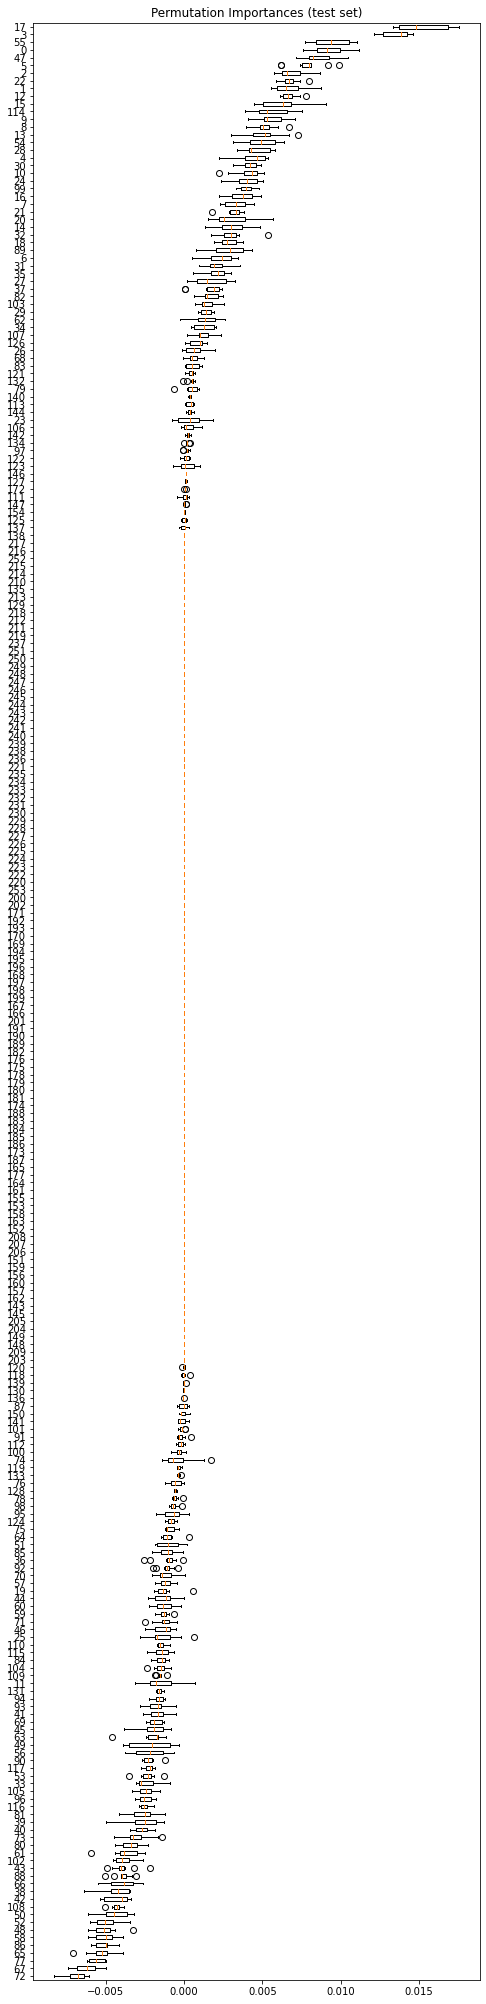

In [216]:
result = permutation_importance(gbc, X, y, n_repeats=10, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(8,36))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")

### Model classification with scaled pi values

In [217]:
%%time
X = pis.div(np.sum(pis, axis=1), axis=0)

gbc = GradientBoostingClassifier(n_estimators=500, min_samples_leaf=10)
gbc.fit(X, y)

scaled_pi_res = {}
for habitat, pi in cyprus_pis.items():
    pi = zero_pad(pi, X)/np.sum(pi)
    result = gbc.predict_proba(pi.reshape(1, -1))
    scaled_pi_res[habitat] = result[0]
scaled_pi_res = pd.DataFrame(scaled_pi_res, index=gbc.classes_).T
scaled_pi_res


Pb [[0.90305802 0.02206703 0.07487495]]
Qa [[0.98645976 0.00248183 0.01105842]]
Cb [[0.0050127  0.99149104 0.00349625]]
Pn [[0.68451575 0.22867562 0.08680864]]
['competition' 'filtering' 'neutral']
CPU times: user 11min 16s, sys: 0 ns, total: 11min 16s
Wall time: 11min 11s


Text(0.5, 1.0, 'Permutation Importances (test set)')

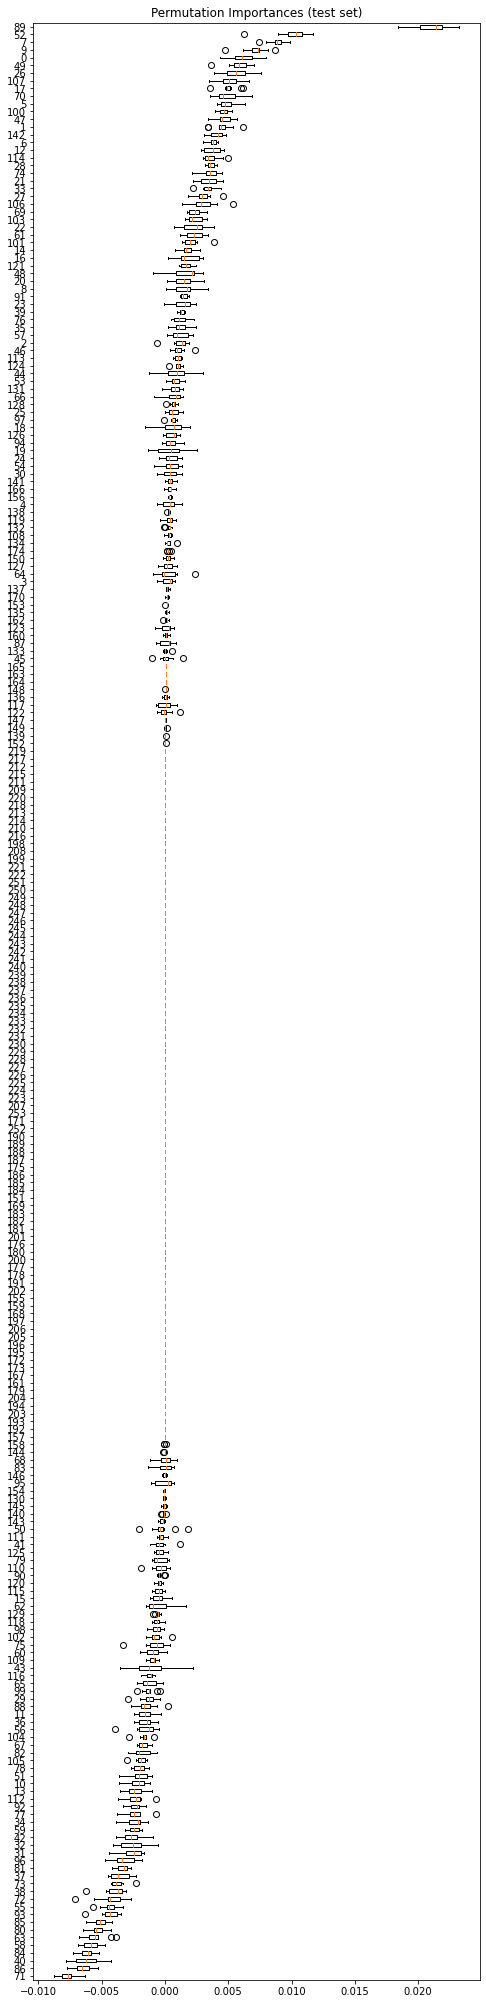

In [218]:
result = permutation_importance(gbc, X, y, n_repeats=10, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots(figsize=(8,36))
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")

### Model classification with hill numbers

In [231]:
%%time
X = all_sims_params_df[["local_S", "pi_h1", "pi_h2", "pi_h3"]]

gbc = GradientBoostingClassifier(n_estimators=500, min_samples_leaf=10)
gbc.fit(X, y)

raw_hill_res = {}
for habitat, hills in cyprus_hills.items():
    result = gbc.predict_proba(np.array(hills).reshape(1, -1))
    raw_hill_res[habitat] = result[0]
raw_hill_res = pd.DataFrame(raw_hill_res, index=gbc.classes_).T
raw_hill_res

CPU times: user 31.9 s, sys: 0 ns, total: 31.9 s
Wall time: 31.6 s


,competition,filtering,neutral
Pb,0.000296,0.999702,0.000002
Qa,0.001503,0.998465,0.000031
Cb,0.002779,0.992130,0.005091
Pn,0.006987,0.992526,0.000488


In [230]:
raw_hill_res
#raw_hill_res = pd.DataFrame.from_records(raw_hill_res, index=gbc.classes_).T
#raw_hill_res

{'Pb': array([[2.96323306e-04, 9.99701558e-01, 2.11856818e-06]]),
 'Qa': array([[1.50328091e-03, 9.98465377e-01, 3.13420042e-05]]),
 'Cb': array([[0.00277934, 0.99212986, 0.0050908 ]]),
 'Pn': array([[6.98656322e-03, 9.92525614e-01, 4.87823016e-04]])}

Text(0.5, 1.0, 'Permutation Importances (test set)')

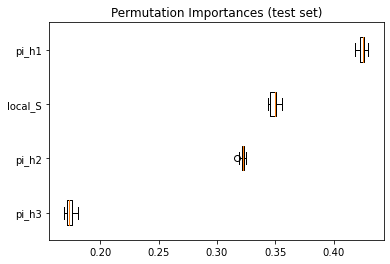

In [220]:
result = permutation_importance(gbc, X, y, n_repeats=10, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")

### Model classification with hill scaled numbers

In [232]:
%%time
# Drop local richness and scale hill numbers by local richess
X = all_sims_params_df[["pi_h1", "pi_h2", "pi_h3"]].div(all_sims_params_df["local_S"], axis=0)

gbc = GradientBoostingClassifier(n_estimators=500, min_samples_leaf=10)
gbc.fit(X, y)

scaled_hill_res = {}
for habitat, hills in cyprus_hills.items():
    hills = np.array(hills)[1:]/hills[0]
    result = gbc.predict_proba(hills.reshape(1, -1))
    scaled_hill_res[habitat] = result[0]
scaled_hill_res = pd.DataFrame(scaled_hill_res, index=gbc.classes_).T
scaled_hill_res

CPU times: user 28.1 s, sys: 0 ns, total: 28.1 s
Wall time: 27.9 s


,competition,filtering,neutral
Pb,0.002876,0.994510,0.002614
Qa,0.005331,0.991616,0.003054
Cb,0.001445,0.996714,0.001841
Pn,0.007114,0.984588,0.008298


Text(0.5, 1.0, 'Permutation Importances (test set)')

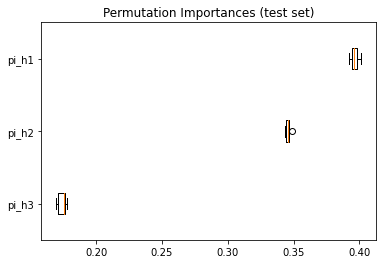

In [222]:
result = permutation_importance(gbc, X, y, n_repeats=10, n_jobs=-1)
sorted_idx = result.importances_mean.argsort()

fig, ax = plt.subplots()
ax.boxplot(result.importances[sorted_idx].T,
           vert=False, labels=X.columns[sorted_idx])
ax.set_title("Permutation Importances (test set)")

## Estimate parameters from raw data

In [ ]:
targets = ["J", "local_obs_time(gen)", "local_obs_time(eq)", "colrate",
           "ClaDS_alpha", "ClaDS_sigma", "ClaDS_m"]
pis = ntaxa300_loc_df.T.apply(lambda y: sorted([x["pi"] for x in y.dropna()], reverse=True))
pis = pd.DataFrame.from_records(pis).fillna(0)

X = pis
y = ntaxa300_params_df[targets]
print(len(X), len(y))
X

In [88]:
rf_rgr = RandomForestRegressor(max_depth=5, random_state=0, n_jobs=-1, n_estimators=500)
rf_rgr.fit(X, y)

rf_preds = pd.DataFrame([], columns=targets, index=habitats)
for h in habitats:
    empirical_pis = zero_pad(cyprus_pis[h], X).reshape(1, -1)
    pred = rf_rgr.predict(empirical_pis)
    rf_preds.loc[h] = pred
rf_preds

,J,local_obs_time(gen),local_obs_time(eq),colrate,ClaDS_alpha,ClaDS_sigma,ClaDS_m
Pb,30432.112865,678.786146,0.701846,0.003077,0.74995,0.242872,0.775415
Qa,24346.093636,640.652818,0.710692,0.003119,0.7427,0.241969,0.767746
Cb,10491.048876,526.639499,0.717123,0.003908,0.724001,0.215434,0.742666
Pn,11723.925592,512.860985,0.715199,0.003733,0.720926,0.224761,0.741241


In [89]:
gb_preds = pd.DataFrame([], columns=targets, index=habitats)
for t in targets:
    print(t)
    gb_rgr = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=500)
    gb_rgr.fit(X, y[t])

    for h in habitats:
        empirical_pis = zero_pad(cyprus_pis[h], X).reshape(1, -1)
        pred = gb_rgr.predict(empirical_pis)
        gb_preds[t][h] = pred[0]
gb_preds

J
local_obs_time(gen)
local_obs_time(eq)
colrate
ClaDS_alpha
ClaDS_sigma
ClaDS_m


,J,local_obs_time(gen),local_obs_time(eq),colrate,ClaDS_alpha,ClaDS_sigma,ClaDS_m
Pb,31980.07549,1498.721953,0.824328,0.001742,0.74139,0.27344,0.79269
Qa,32318.560698,1245.88019,0.801335,0.002949,0.68806,0.240513,0.741784
Cb,5139.876961,901.787838,0.776421,0.004623,0.741262,0.189199,0.788229
Pn,10488.226526,563.403612,0.773922,0.003906,0.678736,0.277212,0.746864


### Predict parameters from Hill numbers

In [92]:
#params_df, loc_df = iBioGen.util.load_local_sims(simfile)
X = ntaxa300_params_df[["local_S", "pi_h1", "pi_h2", "pi_h3"]]

In [90]:
rf_rgr = RandomForestRegressor(max_depth=5, random_state=0, n_jobs=-1, n_estimators=500)
rf_rgr.fit(X, y)

rf_hill_preds = pd.DataFrame([], columns=targets, index=habitats)
for h in habitats:
    empirical_pis = np.array(cyprus_hills[h]).reshape(1, -1)
    pred = rf_rgr.predict(empirical_pis)
    rf_hill_preds.loc[h] = pred
rf_hill_preds

,J,local_obs_time(gen),local_obs_time(eq),colrate,ClaDS_alpha,ClaDS_sigma,ClaDS_m
Pb,72246.993957,7413.172281,0.739814,0.002715,0.743106,0.258052,0.771015
Qa,68927.354567,25616.601898,0.745787,0.002586,0.7515,0.261074,0.780202
Cb,32485.763416,1185.862913,0.751526,0.002369,0.759286,0.261623,0.788732
Pn,55828.198952,1566.8753,0.748302,0.002391,0.745589,0.26021,0.773982


In [91]:
gb_hill_preds = pd.DataFrame([], columns=targets, index=habitats)
for t in targets:
    print(t)
    gb_rgr = GradientBoostingRegressor(max_depth=5, random_state=0, n_estimators=500)
    gb_rgr.fit(X, y[t])

    for h in habitats:
        empirical_pis = np.array(cyprus_hills[h]).reshape(1, -1)
        pred = gb_rgr.predict(empirical_pis)
        gb_hill_preds[t][h] = pred[0]
gb_hill_preds

J
local_obs_time(gen)
local_obs_time(eq)
colrate
ClaDS_alpha
ClaDS_sigma
ClaDS_m


,J,local_obs_time(gen),local_obs_time(eq),colrate,ClaDS_alpha,ClaDS_sigma,ClaDS_m
Pb,84492.40223,4457.789464,0.789351,0.004313,0.835001,0.319952,0.80175
Qa,85475.151919,4906.750737,0.843845,0.004016,0.812518,0.32012,0.820254
Cb,68536.956757,1271.563557,0.547528,0.001934,0.823068,0.252392,0.802338
Pn,54506.70384,1906.927578,0.795269,0.003519,0.739463,0.226131,0.78688


In [93]:
gbq_hill_lower = pd.DataFrame([], columns=targets, index=habitats)
gbq_hill_upper = pd.DataFrame([], columns=targets, index=habitats)
for t in targets:
    print(t)
    gbq_rgr = GradientBoostingRegressor(max_depth=5,
                                       n_estimators=500, min_samples_leaf=9,
                                       loss='quantile', alpha=0.95)
    gbq_rgr.fit(X, y[t])

    for h in habitats:
        empirical_pis = np.array(cyprus_hills[h]).reshape(1, -1)
        pred = gbq_rgr.predict(empirical_pis)
        gbq_hill_upper[t][h] = pred[0]

    gbq_rgr.set_params(alpha=0.05)
    gbq_rgr.fit(X, y[t])

    for h in habitats:
        empirical_pis = np.array(cyprus_hills[h]).reshape(1, -1)
        pred = gbq_rgr.predict(empirical_pis)
        gbq_hill_lower[t][h] = pred[0]
display(gbq_hill_lower)
display(gbq_hill_upper)

J
local_obs_time(gen)
local_obs_time(eq)
colrate
ClaDS_alpha
ClaDS_sigma
ClaDS_m


,J,local_obs_time(gen),local_obs_time(eq),colrate,ClaDS_alpha,ClaDS_sigma,ClaDS_m
Pb,55642.111751,217.666969,0.547319,0.002881,0.642934,0.154379,0.657125
Qa,43993.39137,258.540514,0.551909,0.001777,0.64039,0.127323,0.661876
Cb,18292.283794,301.989897,0.556338,0.001053,0.652551,0.151211,0.661595
Pn,30265.373762,312.917524,0.530565,0.00138,0.639621,0.127974,0.662504


,J,local_obs_time(gen),local_obs_time(eq),colrate,ClaDS_alpha,ClaDS_sigma,ClaDS_m
Pb,92863.87019,45099.388103,0.944371,0.004787,0.880289,0.376618,0.910209
Qa,97036.56992,67856.328066,0.952758,0.004607,0.874092,0.385164,0.921049
Cb,62761.405108,1871.147244,0.910589,0.004194,0.868872,0.370483,0.906663
Pn,88965.723459,30092.343387,0.915466,0.004375,0.880716,0.368155,0.906107


# Trash below here

(array([821., 719., 603., 488., 395., 250., 170.,  75.,  23.,   5.]),
 array([ 81. ,  97.5, 114. , 130.5, 147. , 163.5, 180. , 196.5, 213. ,
        229.5, 246. ]),
 <BarContainer object of 10 artists>)

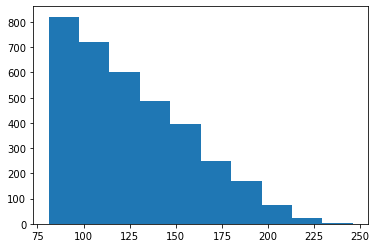

In [143]:
#all_sims_params_df[all_sims_params_df["local_S"] == 100]
plt.hist(all_sims_params_df["local_S"])